In [15]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

In [16]:
with open('demosat.dimacs', 'r') as f:
    dimacs = f.read()
#dimacs = dimacs[:-1].split('\n')
print(dimacs)

p cnf 3 3
1 2 -3 0
2 -3 -1 0
-3 -1 0
-1 -2 0


In [17]:
oracle = PhaseOracle.from_dimacs_file('demosat.dimacs')
oracle.draw()

q_0: ──────────o──
               │  
q_1: ──────o───■──
     ┌───┐ │ ┌───┐
q_2: ┤ X ├─■─┤ X ├
     └───┘   └───┘

In [18]:
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [19]:
v = Verifier('demosat.dimacs')   
v.is_correct('101')

False

In [20]:
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=v.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
result.top_measurement

'110'

In [21]:
from collections import defaultdict
dd = defaultdict(list)

for d in result.circuit_results : # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
for key in dd:
    dd[key] = sum(dd[key])
print(dd)

defaultdict(<class 'list'>, {'101': 270, '011': 242, '010': 257, '111': 228, '100': 282, '000': 237, '110': 265, '001': 267})


[{'101': 136, '011': 115, '010': 129, '111': 112, '100': 155, '000': 120, '110': 125, '001': 132}, {'000': 117, '010': 128, '110': 140, '001': 135, '011': 127, '101': 134, '100': 127, '111': 116}]


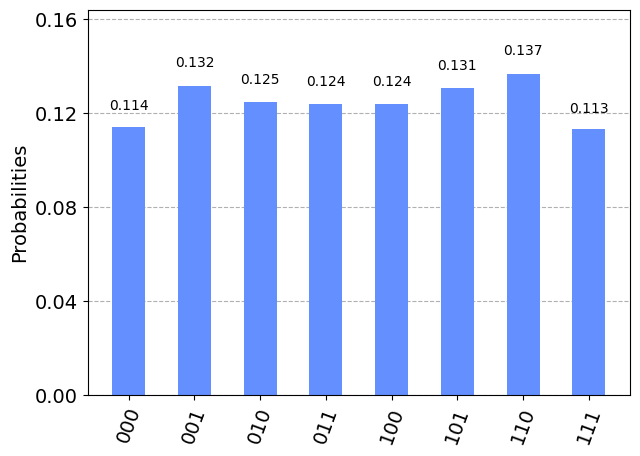

In [22]:
print(result.circuit_results)
plot_histogram(result.circuit_results[-1])

In [23]:
from qiskit.test.mock import FakeBelem
belem = FakeBelem()

In [24]:
from qiskit.compiler import transpile

# transpile the circuit for ibmq_belem
qc = grover.construct_circuit(problem, max(result.iterations))
qc.measure_all()
grover_compiled = transpile(qc, backend=belem, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

gates =  OrderedDict([('rz', 23), ('sx', 16), ('cx', 12), ('measure', 3), ('barrier', 1)])
depth =  34


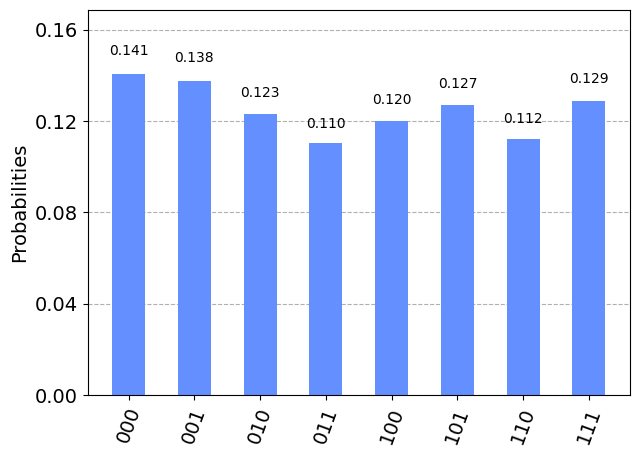

In [25]:
from qiskit import assemble
counts = belem.run(grover_compiled).result().get_counts()
plot_histogram(counts)

In [26]:
from qiskit import IBMQ
from qiskit import execute
IBMQ.save_account('d4b76750e3668e26bf7203d9be2a923e8d922d957c6ef67311806dd0ecb5fc6558fd88ca6611392a2740fee1caf0dfdf91b4095c0194b6f02d333fb46fc44df9', overwrite=True)

In [27]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('ibmq_belem')
qc_compiled = transpile(qc, backend=belem, optimization_level=3)
circuit_list.append(qc_compiled)

ibmqfactory.load_account:WARNING:2022-08-16 10:01:11,583: Credentials are already in use. The existing account in the session will be replaced.


In [28]:
job = execute(circuit_list,backend = device,shots = 1024)
print(job.job_id())

62fba331c28725fcae97f33f


Job Status: job has successfully run


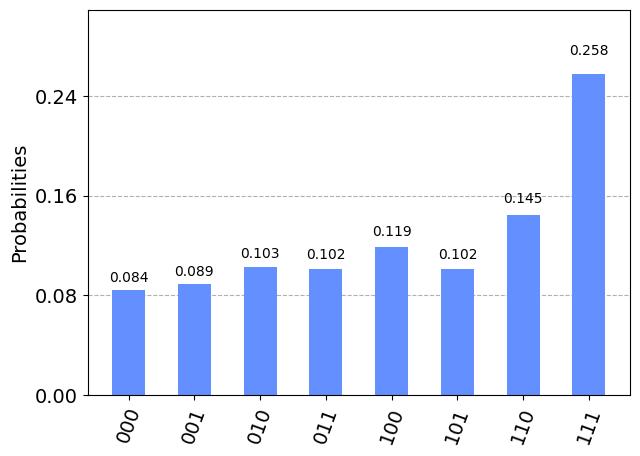

In [14]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)
device_result = job.result()
plot_histogram(device_result.get_counts())

In [15]:
qc_answer = max(device_result.get_counts(), key=device_result.get_counts().get)
print(qc_answer)
v.is_correct(qc_answer)

111


True

In [2]:
circuit_list = []